First we import some functions:

In [1]:
from datetime import datetime, timedelta
from mplsoccer import VerticalPitch
from matplotlib import animation
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import imageio.v2 as iio
from tqdm import tqdm
import pandas as pd
import matplotlib
import zipfile
import shutil
import time
import json
import enum
import mplsoccer as mpls
import seaborn as sns
from soccerbars import soccerbar
import os
import numpy as np
import ast
from adjustText import adjust_text

# set pandas option to show columns of a dataframe
pd.set_option('display.max_columns', None)

# Soccerbars

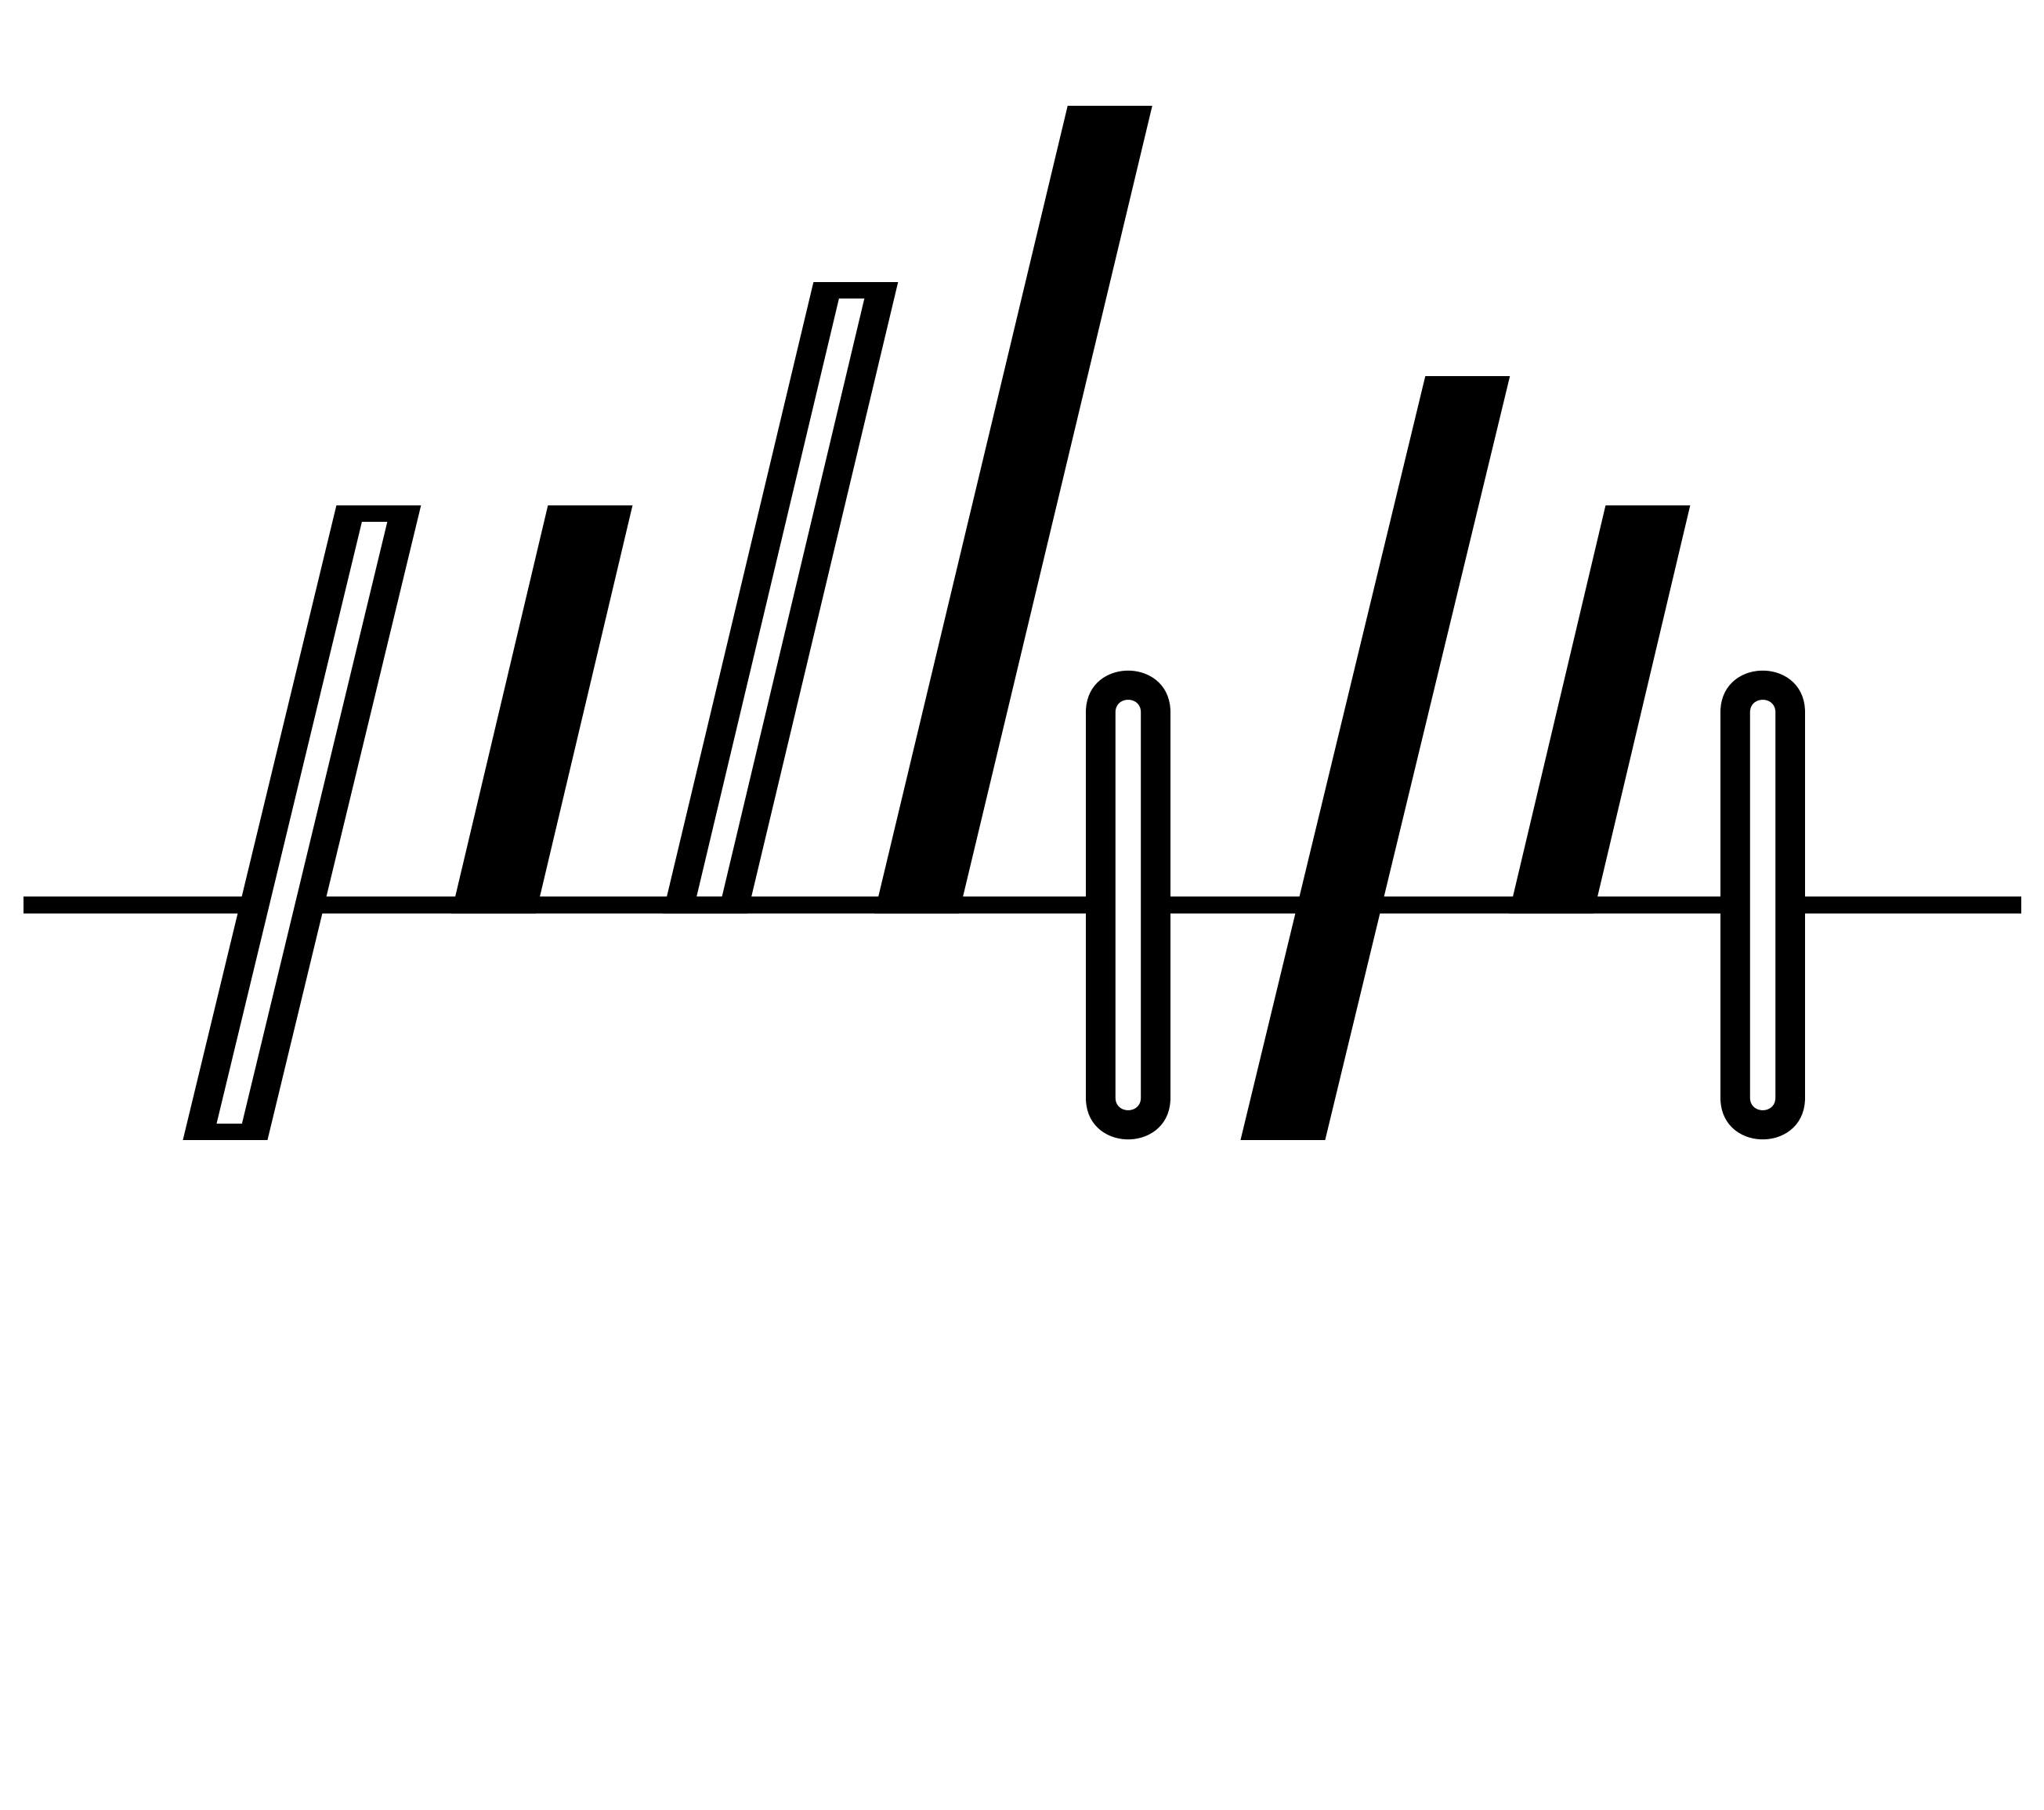

<Axes: >

In [2]:
soccerbar([
    (1, 2, 0, 7, 1, 3, 2, 1), #home_team_score
    (2, 0, 4, 0, 1, 1, 0, 1), #away_team_score
    (True, False, True, False, True, False, False, True)],#away_game
          outlined=True, output_path="soccerbars_england_no_label.png")


# Runs

We start off by creating a function that accesses all the dynamic events files from the skillcorner folders.
The relevant match_ids on are: 726848, 1381470, 1381488, 1381509

In [7]:
def CreateDynamicDF_England(match_id):
#   dynamic_events_path = f'C:\\Users\\pauls\\Desktop\\Studium\\Soccer Analytics\\data\\input\\skillcorner\\{match_id}\\{match_id}_dynamic_events.csv'
    dynamic_events_path = f'/home/paul/Desktop/Studium/Abgeschlossen/2. Semester/Soccer Analytics/data/input/skillcorner/{match_id}/{match_id}_dynamic_events.csv'
    
    dynamic_df = pd.read_csv(dynamic_events_path)
    return dynamic_df
    
dynamic_df_726848 = CreateDynamicDF_England(726848)
dynamic_df_1381470 = CreateDynamicDF_England(1381470)
dynamic_df_1381488 = CreateDynamicDF_England(1381488)
dynamic_df_1381509 = CreateDynamicDF_England(1381509)

Now we'll bind all the dynamic_dfs together to have one dataframe of all of England's runs (where data was available):

In [8]:
dynamic_df_all = pd.concat([dynamic_df_726848,dynamic_df_1381470, dynamic_df_1381488, dynamic_df_1381509])
dynamic_df_all.shape

(1834, 93)

In [9]:
runs_breakdown = dynamic_df_all['event_subtype'].value_counts()

runs_breakdown_df = runs_breakdown.reset_index()
runs_breakdown_df.columns = ['event_subtype', 'count']

# Display the DataFrame
print(runs_breakdown_df)

           event_subtype  count
0  run_ahead_of_the_ball    535
1           coming_short    297
2                support    294
3           dropping_off    201
4         cross_receiver    135
5                 behind    117
6           pulling_wide    107
7                overlap     54
8     pulling_half_space     47
9               underlap     47


To make it a bit more interesting, we'll only consider runs that are classified as having led to a shot:

In [10]:
dynamic_df_all_shots=dynamic_df_all[dynamic_df_all['lead_to_shot']==1]

runs_shots_breakdown = dynamic_df_all_shots['event_subtype'].value_counts()
# Convert the Series to a DataFrame
runs_shots_breakdown_df = runs_shots_breakdown.reset_index()
runs_shots_breakdown_df.columns = ['event_subtype', 'count']

# Display the DataFrame
print(runs_shots_breakdown_df)

           event_subtype  count
0  run_ahead_of_the_ball     45
1         cross_receiver     31
2                support     21
3                 behind     20
4                overlap     12
5           coming_short      6
6           pulling_wide      4
7               underlap      3
8           dropping_off      1
9     pulling_half_space      1


Now we want to find out which players where mainly involved in these runs:

In [ ]:
# First, create a grouped DataFrame that counts each player's occurrences in each event_subtype
England = dynamic_df_all_shots[dynamic_df_all_shots['team_shortname']=='England']
grouped = England.groupby('event_subtype')['player_name'].value_counts().unstack(fill_value=0)

# Now, for each event_subtype, we find the players with the most and second most runs
# We also retrieve the corresponding counts
top_players = grouped.apply(lambda x: pd.Series(x.nlargest(2).index, index=['most_runs', 'second_most_runs']), axis=1)
top_counts = grouped.apply(lambda x: pd.Series(x.nlargest(2).values, index=['count_most_runs', 'count_second_most_runs']), axis=1)

# Combine the information into one DataFrame
combined_df = pd.concat([top_players, top_counts], axis=1).reset_index()

# Merge with the original runs_breakdown_df to get the total counts as well
runs_shots_breakdown_df = runs_shots_breakdown.reset_index()
runs_shots_breakdown_df.columns = ['event_subtype', 'total_count']
final_df = runs_shots_breakdown_df.merge(combined_df, on='event_subtype')

final_df=final_df.iloc[:,[0,1,2,4,3,5]]

print(final_df)

           event_subtype  total_count    most_runs  count_most_runs  \
0  run_ahead_of_the_ball           45      B. Saka                5   
1         cross_receiver           31      H. Kane                4   
2                support           21     R. Lewis                3   
3                 behind           20     P. Foden                4   
4                overlap           12    K. Walker                3   
5           coming_short            6      D. Rice                1   
6           pulling_wide            4      B. Saka                1   
7               underlap            3  B. Chilwell                1   
8           dropping_off            1  J. Maddison                1   
9     pulling_half_space            1     P. Foden                1   

  second_most_runs  count_second_most_runs  
0         P. Foden                       5  
1         P. Foden                       4  
2          H. Kane                       2  
3          B. Saka                    

In [23]:
final_df

,event_subtype,total_count,most_runs,count_most_runs,second_most_runs,count_second_most_runs
0,run_ahead_of_the_ball,45,B. Saka,5,P. Foden,5
1,cross_receiver,31,H. Kane,4,P. Foden,4
2,support,21,R. Lewis,3,H. Kane,2
3,behind,20,P. Foden,4,B. Saka,2
4,overlap,12,K. Walker,3,B. Saka,1
5,coming_short,6,D. Rice,1,J. Bellingham,1
6,pulling_wide,4,B. Saka,1,J. Grealish,1
7,underlap,3,B. Chilwell,1,B. Saka,0
8,dropping_off,1,J. Maddison,1,B. Chilwell,0
9,pulling_half_space,1,P. Foden,1,B. Chilwell,0


Now we will try to visualise the runs that England made, which lead to shots. Let's start with the run_ahead_of_the_ball runs:
As a starting point, we take inspiration from this snippet: https://gitlab.ethz.ch/socceranalytics/uefa-euro-2024/-/snippets/1036

In [21]:
#test_df=dynamic_df_all.iloc[1:5]
#test_df.to_excel("test_df.xlsx")

dynamic_df_all.shape
shots=dynamic_df_all_shots=dynamic_df_all[dynamic_df_all['lead_to_shot']==1]
shots.shape

(144, 93)

In [22]:
shots

,index,match_id,frame_start,frame_end,time_start,time_end,period,attacking_side_id,attacking_side,minute_start,second_start,duration,event_type_id,event_type,event_subtype_id,event_subtype,player_id,player_name,player_in_possession_id,player_in_possession_name,player_possession_frame_start,team_id,team_shortname,x_start,y_start,channel_id_start,channel_start,third_id_start,third_start,penalty_area_start,x_end,y_end,channel_id_end,channel_end,third_id_end,third_end,penalty_area_end,trajectory_angle,distance_covered,speed_avg,targeted,received,lead_to_shot,lead_to_goal,dangerous,difficult_pass_target,xthreat,xpass_completion,passing_option_score,in_to_out,out_to_in,simultaneous_runs,give_and_go,passing_option,passing_option_start,location_to_player_in_possession_id_start,location_to_player_in_possession_start,location_to_player_in_possession_id_end,location_to_player_in_possession_end,distance_to_player_in_possession_start,distance_to_player_in_possession_end,player_in_possession_x_start,player_in_possession_y_start,player_in_possession_channel_id_start,player_in_possession_channel_start,player_in_possession_third_id_start,player_in_possession_third_start,player_in_possession_penalty_area_start,player_in_possession_x_end,player_in_possession_y_end,player_in_possession_channel_id_end,player_in_possession_channel_end,player_in_possession_third_id_end,player_in_possession_third_end,player_in_possession_penalty_area_end,delta_to_last_defensive_line_start,delta_to_last_defensive_line_end,delta_to_last_defensive_line_gain,last_defensive_line_height_start,last_defensive_line_height_end,last_defensive_line_height_gain,intended_run_behind,break_defensive_line,push_defensive_line,inside_defensive_shape_start,inside_defensive_shape_end,separation_start,separation_end,separation_gain,received_in_space,opponents_ahead_start,opponents_ahead_end,opponents_overtaken
88,88,726848.0,13153,13171,21:54.3,21:56.1,1,1,left_to_right,21,54,1.8,1,off_ball_run,9,support,32468,H. Sudakov,12549,R. Malinovskyi,13151,400.0,Ukraine,-0.78,4.29,3,center,2,middle_third,False,7.43,2.70,3,center,2,middle_third,False,-10.96,8.43,16.76,False,False,True,False,False,True,0.0168,0.5732,0.6626,False,False,4,True,True,True,1,behind,1,behind,12.09,3.35,5.22,-6.21,3,center,2,middle_third,False,10.55,1.47,3,center,2,middle_third,False,14.99,10.93,-4.06,38.29,34.14,-4.15,False,False,False,True,True,3.05,0.82,-2.23,False,5,5,0
89,89,726848.0,13159,13214,21:54.9,22:00.4,1,1,left_to_right,21,54,5.5,1,off_ball_run,3,cross_receiver,12547,O. Karavaev,12549,R. Malinovskyi,13151,400.0,Ukraine,4.58,-28.18,5,wide_right,2,middle_third,False,33.90,-14.61,4,half_space_right,3,attacking_third,False,24.84,31.98,21.10,False,False,True,False,False,False,0.0144,0.8783,0.7093,False,True,4,False,True,True,2,same_line,2,same_line,24.57,25.50,6.15,-3.66,3,center,2,middle_third,False,34.63,10.88,2,half_space_left,3,attacking_third,False,10.29,10.82,0.53,37.63,7.78,-29.85,False,False,False,False,False,22.46,11.38,-11.08,False,4,5,-1
90,90,726848.0,13165,13209,21:55.5,21:59.9,1,1,left_to_right,21,55,4.4,1,off_ball_run,1,behind,30704,M. Mudryk,12549,R. Malinovskyi,13151,400.0,Ukraine,9.22,13.26,2,half_space_left,2,middle_third,False,39.54,7.61,3,center,3,attacking_third,True,-10.56,30.96,25.09,False,False,True,False,True,False,0.0522,0.7675,0.9458,False,False,4,False,True,True,2,same_line,3,ahead,14.23,6.64,7.89,-0.91,3,center,2,middle_third,False,33.42,10.19,2,half_space_left,3,attacking_third,False,6.97,2.03,-4.94,36.31,10.93,-25.38,True,False,True,True,True,7.23,1.52,-5.71,False,3,2,1
91,91,726848.0,13166,13214,21:55.6,22:00.4,1,1,left_to_right,21,55,4.8,1,off_ball_run,3,cross_receiver,12438,R. Yaremchuk,12549,R. Malinovskyi,13151,400.0,Ukraine,10.09,-4.92,3,center,2,middle_third,False,43.70,-6.59,3,center,3,attacking_third,True,-2.84,35.07,26.12,False,False,True,False,True,True,0.2573,0.4293,0.7139,False,False,4,False,True,True,2,same_line,3,ahead,4.78,19.68,8.28,-0.50,3,center,2,middle_third,Fal

In [26]:
#As a starting point, we took inspiration from this snippet: https://gitlab.ethz.ch/socceranalytics/uefa-euro-2024/-/snippets/1036
def show_runs(df: pd.DataFrame, title: str = None, lead_to_shot: bool = None, team: str = None, type: str = None, runners: list = None):
    """This function creates a plot of all runs according to the specifications above"""
    runs=df
    
    if lead_to_shot!=None: runs=runs[runs['lead_to_shot']==lead_to_shot]
    if team!=None: runs = runs[runs["team_shortname"] == team]
    if type!=None: runs = runs[(runs["event_subtype"] == type)]
    if runners: runs = runs[runs["player_name"].isin(runners)]
    
    #Note: In the games concerned England played 3 times in Wembley and once in the National Arena Todor Proeski
    #Both are 105*68m big, so we don't have to think about conversions etc.
    #https://www.transfermarkt.co.uk/stadion/stadion/verein/5148/saison_id/2022
    pitch = mpls.Pitch(pitch_type='custom', pitch_length=105, pitch_width=68,
                    axis=True, label=True, 
                    pitch_color='grass', line_color='white', stripe=True)  
    fig, ax = pitch.draw()
    
    for _, row in runs.iterrows():
        # Since skillcorner assumes (0,0) to be at the center circle, we have to make some adjustments
        x_start_adj = row['x_start'] + 105/2
        y_start_adj = row['y_start'] + 68/2
        x_end_adj = row['x_end'] + 105/2
        y_end_adj = row['y_end'] + 68/2

        pitch.arrows(x_start_adj, y_start_adj, x_end_adj, y_end_adj,
                     width=2, headwidth=6, headlength=10, color='blue', ax=ax)
        
        # Markers for start points
        pitch.scatter(x_start_adj, y_start_adj, color='blue', ax=ax, s=10)
        #pitch.scatter(x_end_adj, y_end_adj, color='green', ax=ax, s=10, zorder=5)

    #Writing a title
    if title is None:
        parts = 'Runs'

        if lead_to_shot==True:
            parts = parts + ' that led to shots'
        parts = parts + ': '
        if team:
            parts = parts + team
        if type:
            parts = parts + ' - ' + type
        if runners:
            list_runners=', '.join(runners)
            parts = parts + ' - ' + list_runners
    

    plt.title(parts)
    plt.show()

One particularly interesting plot we can create here is of the runs specified as "cross_receiver" for Harry Kane. This particular plot is very striking, because we can see how much the end points of his runs concentrate around the penalty spot.

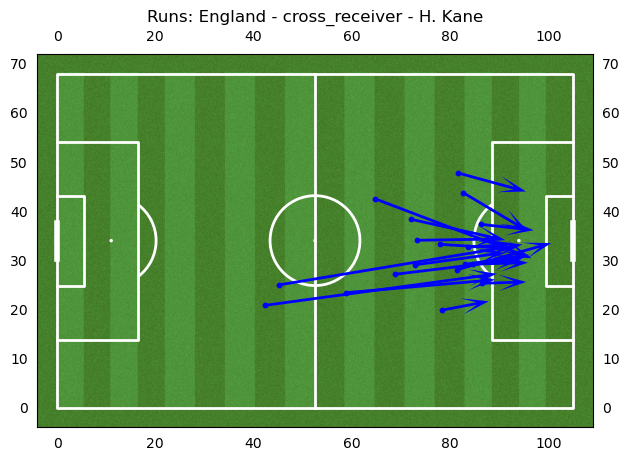

In [25]:
show_runs(dynamic_df_all, lead_to_shot=None, team="England",
          type='cross_receiver', runners=['H. Kane'])

#cross_receiver
#run_ahead_of_the_ball
#behind

## To-Do Later:

In order to better understand, which runs of England are "special" or distinguish them from other teams, we could try to run the same analysis on all other games and all other teams for every game where skillcorner data was available:

# Defensive phase

## Recoveries by area

### For England

/tmp/ipykernel_154157/428437315.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recup_England.loc[:, 'x_percent'] = df_recup_England['location.x']
/tmp/ipykernel_154157/428437315.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recup_England.loc[:, 'y_percent'] = df_recup_England['location.y']
/tmp/ipykernel_154157/428437315.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

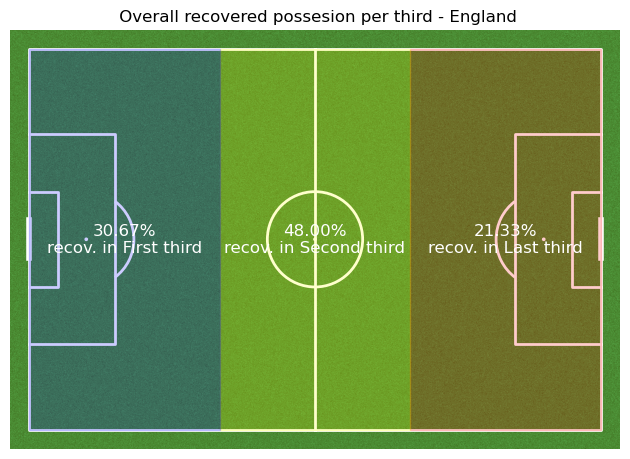

In [27]:
# The directory where your JSON files are stored
#json_folder_path = '/Users/oab/Desktop/SA/SCO/WYSCOUT'
#json_folder_England = r'C:\Users\pauls\Desktop\Studium\Soccer Analytics\data\input\json_files_england'
json_folder_England = r'/home/paul/Desktop/Studium/Abgeschlossen/2. Semester/Soccer Analytics/data/input/json_files_england'


# List to hold DataFrames
dfs_england = []

# Loop through the directory, reading each JSON file
for file_name in os.listdir(json_folder_England):
    if file_name.endswith('.json'):
        file_path = os.path.join(json_folder_England, file_name)
        # Read the JSON file into a DataFrame
        with open(file_path, encoding='utf8') as f:
            js = json.load(f)
            df = pd.json_normalize(js['events'])
            dfs_england.append(df)
            df_concat_England = pd.concat(dfs_england, ignore_index=True)
            
            
# Filtrer pour obtenir les récupérations de possession par l'équipe de Suisse
df_recup_England= df_concat_England[(df_concat_England['team.name'] == 'England') & (df_concat_England['groundDuel.recoveredPossession'] == True ) ]

# Sélectionner seulement les colonnes spécifiques
df_specific_columns = df_recup_England[['player.name', 'matchId', 'team.name', 'location.x', 'location.y','opponentTeam.name','opponentTeam.name']]

# Afficher le DataFrame résultant avec un titre
df_display = df_specific_columns.style.set_caption("Ground duel recovery by England")

# Modified the functions slightly here. Before it was sth like this: df_recup_England['x_percent'] = df_recup_England['location.x'] 
df_recup_England.loc[:, 'x_percent'] = df_recup_England['location.x']
df_recup_England.loc[:, 'y_percent'] = df_recup_England['location.y']
df_recup_England.loc[:, 'x_abs'] = df_recup_England['x_percent'] / 100 * 105  # Convert to absolute coordinates using pitch length of 105 meters
df_recup_England.loc[:, 'y_abs'] = df_recup_England['y_percent'] / 100 * 68   # Convert to absolute coordinates using pitch width of 68 meters

# Initialize the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')
fig, ax = pitch.draw()

# Divide recoveries into thirds based on the x position and calculate proportions for each third
df_recup_England.loc[:,'tier'] = pd.cut(df_recup_England['x_percent'], bins=[0, 33.33, 66.67, 100], labels=['First third', 'Second third', 'Last third'])
proportions = df_recup_England['tier'].value_counts(normalize=True) * 100

# Define colors for each third and add rectangles and percentages for each third
colors = {'Last third': 'red', 'Second third': 'yellow', 'First third': 'blue'}
for tier, color in colors.items():
    x_position = 0 if tier == 'First third' else 40 if tier == 'Second third' else 80
    rect = patches.Rectangle((x_position, 0), 40, 80, color=color, alpha=0.2)
    ax.add_patch(rect)
    # Text positioning at the center of each third
    text_x = x_position + 20
    ax.text(text_x, 40, f'{proportions.get(tier, 0):.2f}%\nrecov. in {tier}', fontsize=12, color='white', ha='center', va='center')
    ax.set_title(f' Overall recovered possesion per third - England')
plt.show()

### For the other favourites of the competition

To get a sense of where England recovers possesion unusually little or often, we also consider teams of a similar calliber as England:

In [32]:
# Create dataframe with all matches, where one of the teams in the list teams played
#path=r"C:\Users\pauls\Desktop\Studium\Soccer Analytics\data"
path = r'/home/paul/Desktop/Studium/Abgeschlossen/2. Semester/Soccer Analytics/data'

favourites = ['France', 'Germany', 'Spain', 'Portugal', 'Italy', 'Netherlands', 'Belgium']
#path_events = r"C:\Users\pauls\Desktop\Studium\Soccer Analytics\data\input\wyscout"
path_events = r'/home/paul/Desktop/Studium/Abgeschlossen/2. Semester/Soccer Analytics/data/input/wyscout'


In [35]:
matchid_df = pd.read_csv(path+"/matchids.csv")
matchid_df_away = matchid_df[[team in favourites for team in matchid_df["away"]]]
matchid_df_home = matchid_df[[team in favourites for team in matchid_df["home"]]]
matchid_df = matchid_df_home._append(matchid_df_away, ignore_index=True)
# Make list of folders that need to be unzipped
event_folder_list =  os.listdir(Path(path_events))
zip_folder_list = []
folder_list = []
for folder in event_folder_list:
    if folder[-3:] == "zip":
        zip_folder_list.append(folder)
    else:
        folder_list.append(folder)

In [36]:
dfs_favourites = []

for index, row in matchid_df.iterrows():
    # Unzip zipped folders
    wyscout_id = row["wyscout"]
    wyscout_folder = Path(path_events) / Path(str(wyscout_id))
    zip_path = Path(path_events) / Path(str(wyscout_id) + ".zip")
    json_path = wyscout_folder / Path(str(wyscout_id) + ".json")
    
    # Check if the folder already exists
    if not wyscout_folder.exists():
        os.makedirs(wyscout_folder)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(wyscout_folder)
    
    # Load json files and create dataframe
    if json_path.exists():
        with open(json_path, encoding="utf8") as f:
            event = json.load(f)
        events_df = pd.DataFrame(event["events"])
        # Do something with events_df
    else:
        print(f"JSON file for wyscout_id {wyscout_id} does not exist.")
    # Load json files and create dataframe
    with open(Path(path_events) / Path(str(wyscout_id)) / Path(str(wyscout_id) + ".json"), encoding="utf8") as f:
        js = json.load(f)
        df = pd.json_normalize(js['events'])
        dfs_favourites.append(df)
        df_concat = pd.concat(dfs_favourites, ignore_index=True)


/tmp/ipykernel_154157/3166548203.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recup.loc[:, 'x_percent'] = df_recup['location.x']
/tmp/ipykernel_154157/3166548203.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recup.loc[:, 'y_percent'] = df_recup['location.y']
/tmp/ipykernel_154157/3166548203.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

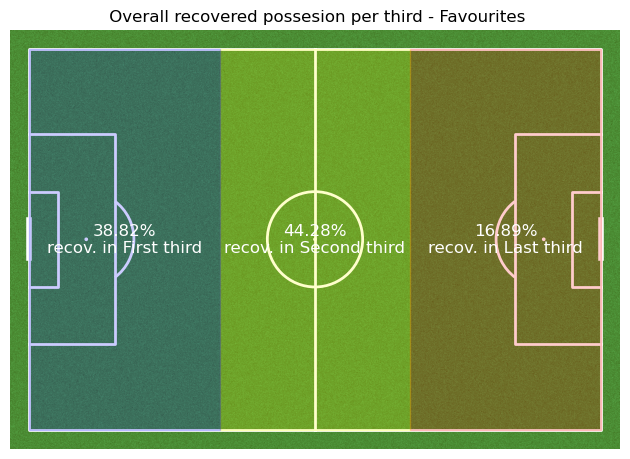

In [37]:

df_recup = df_concat[(df_concat['team.name'].isin(favourites)) & (df_concat['groundDuel.recoveredPossession'] == True)]

# Sélectionner seulement les colonnes spécifiques
df_specific_columns = df_recup[['player.name', 'matchId', 'team.name', 'location.x', 'location.y','opponentTeam.name','opponentTeam.name']]

# Afficher le DataFrame résultant avec un titre
df_display = df_specific_columns.style.set_caption("Ground duel recovery by England")

# Modified the functions slightly here. Before it was sth like this: df_recup['x_percent'] = df_recup['location.x'] 
df_recup.loc[:, 'x_percent'] = df_recup['location.x']
df_recup.loc[:, 'y_percent'] = df_recup['location.y']
df_recup.loc[:, 'x_abs'] = df_recup['x_percent'] / 100 * 105  # Convert to absolute coordinates using pitch length of 105 meters
df_recup.loc[:, 'y_abs'] = df_recup['y_percent'] / 100 * 68   # Convert to absolute coordinates using pitch width of 68 meters

# Initialize the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')
fig, ax = pitch.draw()

# Divide recoveries into thirds based on the x position and calculate proportions for each third
df_recup.loc[:,'tier'] = pd.cut(df_recup['x_percent'], bins=[0, 33.33, 66.67, 100], labels=['First third', 'Second third', 'Last third'])
proportions = df_recup['tier'].value_counts(normalize=True) * 100

# Define colors for each third and add rectangles and percentages for each third
colors = {'Last third': 'red', 'Second third': 'yellow', 'First third': 'blue'}
for tier, color in colors.items():
    x_position = 0 if tier == 'First third' else 40 if tier == 'Second third' else 80
    rect = patches.Rectangle((x_position, 0), 40, 80, color=color, alpha=0.2)
    ax.add_patch(rect)
    # Text positioning at the center of each third
    text_x = x_position + 20
    ax.text(text_x, 40, f'{proportions.get(tier, 0):.2f}%\nrecov. in {tier}', fontsize=12, color='white', ha='center', va='center')
    ax.set_title(f' Overall recovered possesion per third - Favourites')
plt.show()

England does seem to be particularly strong in the middle third.

## PPDA

### PPDA England

In [38]:
#os.listdir(Path(json_folder_England))

# Datenpfade für 10 verschiedene Spiele
file_paths = os.listdir(Path(json_folder_England))

sum_opponent_passes = 0
sum_England_defensive_actions = 0

PPDA_data_England = []

for file_path in file_paths:
    # Zähler für gegnerische Pässe und eigene defensive Aktionen initialisieren
    opponent_passes = 0
    England_defensive_actions = 0
    
    # Teambezeichnung für jedes Spiel initialisieren
    opponent_team = None
    
    full_file_path = Path(json_folder_England) / file_path
    # Daten aus der JSON-Datei einlesen
    with open(full_file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        
        
        # Durch die Ereignisse iterieren und gegnerische Pässe sowie eigene defensive Aktionen zählen
        for event in data['events']:
            if 'location' in event and event['location'] is not None:
                if event['team']['name'] != 'England':
                    opponent_team = event['team']['name']
#                    if 0 <= event['location']['x'] <= 60 and 'pass' in event['type']['primary'] and event['pass']['accurate']:
                    if 0 <= event['location']['x'] <= 40 and 'pass' in event['type']['primary']:
                        opponent_passes += 1
                        sum_opponent_passes += 1
                elif event['team']['name'] == 'England':
                    if 60 <= event['location']['x'] <= 100 and event['type']['primary'] == 'interception':
                        England_defensive_actions += 1
                        sum_England_defensive_actions += 1
                    elif 60 <= event['location']['x'] <= 100 and event['type']['primary'] == 'infraction' and 'foul' in event['type']['secondary']:
                        England_defensive_actions += 1
                        sum_England_defensive_actions += 1
                    elif 60 <= event['location']['x'] <= 100 and event['type']['primary'] == 'duel' and 'defensive_duel' in event['type']['secondary'] : 
                        if event['groundDuel'] is not None and event['groundDuel']['stoppedProgress'] == True:
                            England_defensive_actions += 1
                            sum_England_defensive_actions += 1
                    
        ppda_England = opponent_passes / max(1, England_defensive_actions)  # Avoid division by zero
        
        # Append the data to the list
        PPDA_data_England.append({
            "File": file_path,
            "Opponent Team": opponent_team,
            "Opponent Passes": opponent_passes,
            "England Defensive Actions": England_defensive_actions,
            "PPDA England": ppda_England
        })

PPDA_df_England = pd.DataFrame(PPDA_data_England)
PPDA_df_England['File'] = PPDA_df_England['File'].str.replace('.json', '', regex=False).astype(int)
print("Opponent Passes:", sum_opponent_passes)
print("England Defensive Actions:", sum_England_defensive_actions)
sum_ppda_England = sum_opponent_passes / max(1, sum_England_defensive_actions)  # Avoid division by zero
print(f'Average PPDA England in Qualification: {sum_ppda_England}')


Opponent Passes: 1364
England Defensive Actions: 174
Average PPDA England in Qualification: 7.839080459770115


Now, we'll plot the PPDA by opponent:

In [41]:
matchid_df = pd.read_csv(path+"/matchids.csv")
matchid_df['wyscout'] = matchid_df['wyscout'].astype(int)

merged_df = PPDA_df_England.merge(matchid_df, left_on='File', right_on='wyscout')

#Adding A and H respectively for home and away games
for index, row in merged_df.iterrows():
    if row['home']=='England':
        merged_df.at[index, 'Opponent Team'] = row['Opponent Team'] + " (H)"
    else:
        merged_df.at[index, 'Opponent Team'] = row['Opponent Team'] + " (A)"

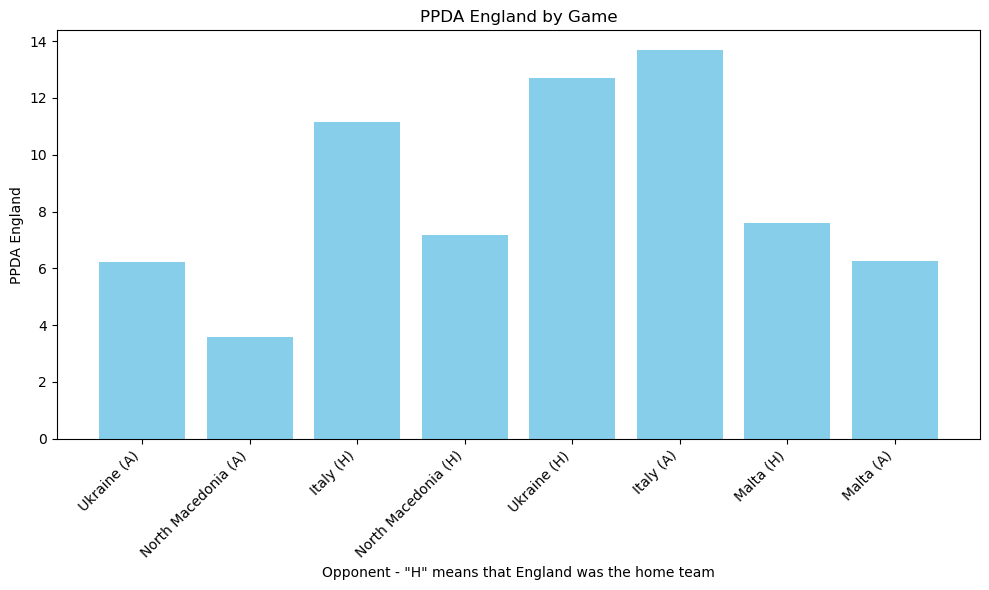

In [42]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(merged_df.index, merged_df['PPDA England'], color='skyblue')
plt.xlabel('Opponent - "H" means that England was the home team')
plt.ylabel('PPDA England')
plt.title('PPDA England by Game')

# Set the x-ticks to be the index of the DataFrame and label them with the opponent teams
plt.xticks(merged_df.index, merged_df['Opponent Team'], rotation=45, ha='right')

plt.tight_layout()  # Adjust layout to make room for the rotated labels
plt.show()

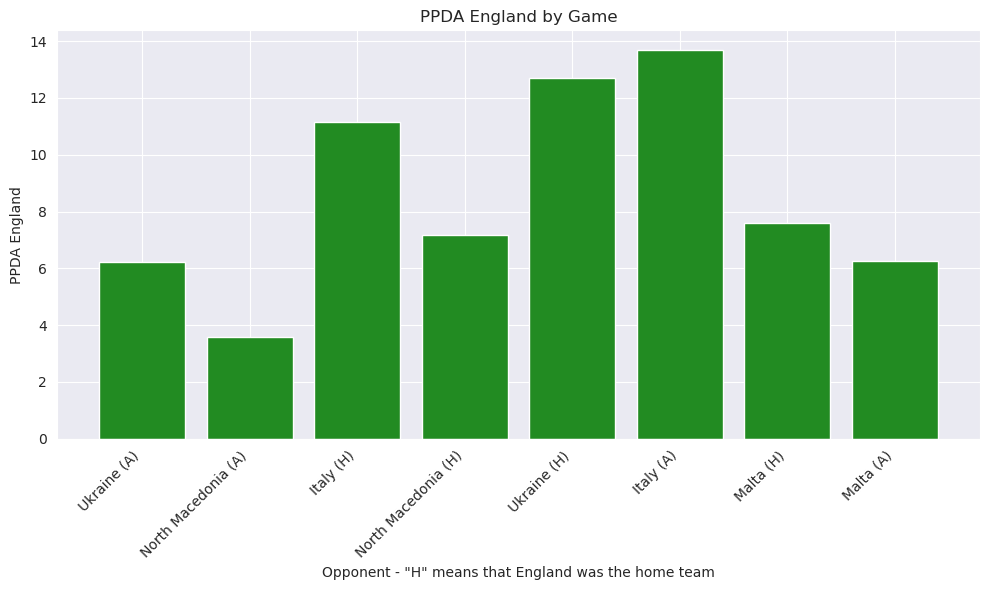

In [43]:
# Plotting the data
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")

# Adjust the bar color to forest-y green
plt.bar(merged_df.index, merged_df['PPDA England'], color='forestgreen')

plt.xlabel('Opponent - "H" means that England was the home team')
plt.ylabel('PPDA England')
plt.title('PPDA England by Game')

# Set the x-ticks to be the index of the DataFrame and label them with the opponent teams
plt.xticks(merged_df.index, merged_df['Opponent Team'], rotation=45, ha='right')

plt.tight_layout()  # Adjust layout to make room for the rotated labels
plt.show()


### PPDA other favourites of the competition

In [83]:
favourites = ['England', 'France', 'Germany', 'Spain', 'Portugal', 'Italy', 'Netherlands', 'Belgium']

filtered_df = df_concat[
    ~(df_concat['team.name'].isin(favourites) & df_concat['opponentTeam.name'].isin(favourites))
]

relevant_ids=matchid_df[
    matchid_df["home"].isin(favourites) ^ matchid_df["away"].isin(favourites)
    ]['wyscout']

ids_df=[]

for team in favourites:
    filtered_df = matchid_df[(matchid_df['home']==team) | (matchid_df['away']==team)]
    wyscout_ids = filtered_df['wyscout'].tolist()
    
    ids_df.append({
        "Team":team,
        "IDs":wyscout_ids
    })
    
ids_list = relevant_ids.tolist()

In [61]:
#base_path = r"C:\Users\pauls\Desktop\Studium\Soccer Analytics\data\input\wyscout"
base_path = r'/home/paul/Desktop/Studium/Abgeschlossen/2. Semester/Soccer Analytics/data/input/wyscout'

# Function to convert IDs to paths
def convert_ids_to_paths(teams_ids, base_path):
    for team in teams_ids:
        team['IDs'] = [f"{base_path}/{id_}/{id_}.json" for id_ in team['IDs']]
#        team['IDs'] = [f"{base_path}\\{id_}.json" for id_ in team['IDs']]
    return teams_ids

# Convert the IDs to paths
converted_teams_ids = convert_ids_to_paths(ids_df, base_path)

#converted_teams_ids

In [63]:
sum_opponent_passes = 0
sum_favourites_defensive_actions = 0

PPDA_data_favourites = []

for team in converted_teams_ids:
    # Zähler für gegnerische Pässe und eigene defensive Aktionen initialisieren
    opponent_passes = 0
    favourites_defensive_actions = 0
        
    # Teambezeichnung für jedes Spiel initialisieren
    opponent_team = None
    sum_opponent_passes = 0
    sum_favourites_defensive_actions = 0
    
    for file_path in team['IDs']:
        # Zähler für gegnerische Pässe und eigene defensive Aktionen initialisieren
        opponent_passes = 0
        favourites_defensive_actions = 0
        
        # Teambezeichnung für jedes Spiel initialisieren
        opponent_team = None
        
        #full_file_path = Path(json_folder_England) / file_paths_favourites
        # Daten aus der JSON-Datei einlesen
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            
            # Durch die Ereignisse iterieren und gegnerische Pässe sowie eigene defensive Aktionen zählen
            for event in data['events']:
                if 'location' in event and event['location'] is not None:
                    if event['team']['name'] != team['Team']: #Opponent team
                        opponent_team = event['team']['name']
    #                    if 0 <= event['location']['x'] <= 60 and 'pass' in event['type']['primary'] and event['pass']['accurate']:
                        if 0 <= event['location']['x'] <= 40 and 'pass' in event['type']['primary']:
                            opponent_passes += 1
                            sum_opponent_passes += 1
                    elif event['team']['name'] == team['Team']: #Favourite team
                        if 60 <= event['location']['x'] <= 100 and event['type']['primary'] == 'interception':
                            favourites_defensive_actions += 1
                            sum_favourites_defensive_actions += 1
                        elif 60 <= event['location']['x'] <= 100 and event['type']['primary'] == 'infraction' and 'foul' in event['type']['secondary']:
                            favourites_defensive_actions += 1
                            sum_favourites_defensive_actions += 1
                        elif 60 <= event['location']['x'] <= 100 and event['type']['primary'] == 'duel' and 'defensive_duel' in event['type']['secondary'] : 
                            if event['groundDuel'] is not None and event['groundDuel']['stoppedProgress'] == True:
                                favourites_defensive_actions += 1
                                sum_favourites_defensive_actions += 1
                        
            ppda_favourites = opponent_passes / max(1, favourites_defensive_actions)  # Avoid division by zero
            
            # Append the data to the list
            
    PPDA_df_favourites = pd.DataFrame(PPDA_data_favourites)
    
    #print("Opponent Passes against", team['Team'], ": ", sum_opponent_passes)
    #print(team['Team'], " Defensive Actions:", sum_favourites_defensive_actions)
    #sum_ppda_team = sum_opponent_passes / max(1, sum_favourites_defensive_actions)  # Avoid division by zero
    #print(f'Average PPDA', team['Team'], 'in Qualification:', sum_ppda_team)
    
    PPDA_data_favourites.append({
                "Team": team['Team'],
                "Opponent Passes": sum_opponent_passes,
                "Defensive Actions": sum_favourites_defensive_actions,
                "PPDA": sum_opponent_passes / max(1, sum_favourites_defensive_actions)
            })
    
    PPDA_df_favourites = pd.DataFrame(PPDA_data_favourites)

In [64]:
PPDA_df_favourites

,Team,Opponent Passes,Defensive Actions,PPDA
0,England,1364,174,7.839080
1,France,1659,202,8.212871
2,Germany,1960,283,6.925795
3,Spain,1028,197,5.218274
4,Portugal,1371,206,6.655340
5,Italy,1488,195,7.630769
6,Netherlands,1278,164,7.792683
7,Belgium,1146,126,9.095238


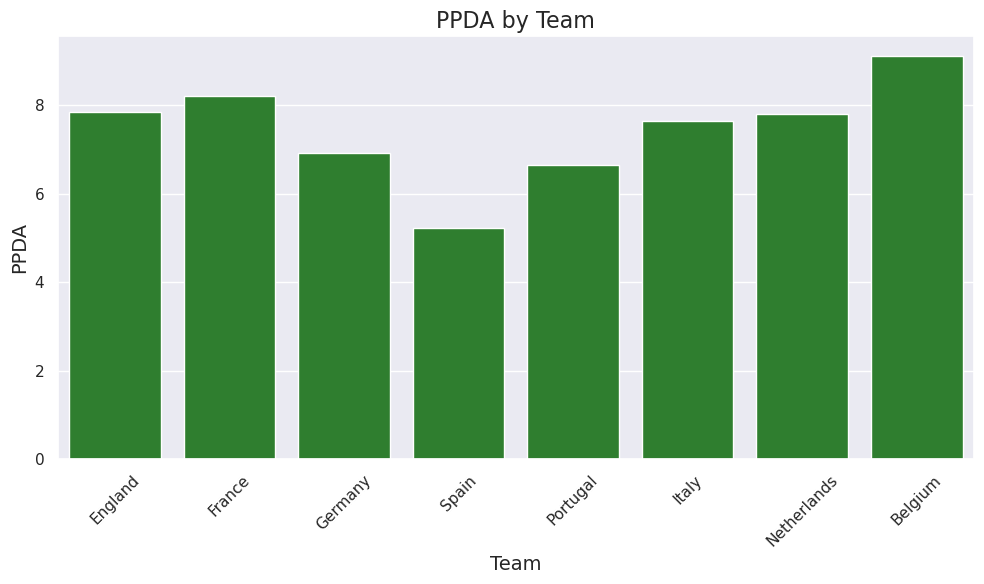

In [65]:
# Set the plot size and style
plt.figure(figsize=(10, 6))
sns.set(style="darkgrid", palette='dark')


# Create a bar plot
bar_plot = sns.barplot(x='Team', y='PPDA', data=PPDA_df_favourites, color='forestgreen')

# Add title and labels
bar_plot.set_title('PPDA by Team', fontsize=16)
bar_plot.set_xlabel('Team', fontsize=14)
bar_plot.set_ylabel('PPDA', fontsize=14)

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

So, while England makes more recoveries in the final third than the favourite teams do on average, they actually have a higher PPDA value when averaging over all actions amongst all favourite teams. This seems to indicate, that they do not press quite as often as their counterparts, but are more successfull than them, when they do.

# Set pieces

In [66]:
#path=r"C:\Users\pauls\Desktop\Studium\Soccer Analytics\data"
path = r'/home/paul/Desktop/Studium/Abgeschlossen/2. Semester/Soccer Analytics/data'


matchid_df = pd.read_csv(path+"/matchids.csv")
england_df = matchid_df[(matchid_df['home']=='England') | (matchid_df['away']=='England')]
england_ids = england_df['wyscout'].tolist()

First we have to read in all the Wyscout data for England games:

In [67]:

# List to hold DataFrames
dfs_england = []

# Loop through the directory, reading each JSON file
for file_name in os.listdir(json_folder_England):
    if file_name.endswith('.json'):
        file_path = os.path.join(json_folder_England, file_name)
        # Read the JSON file into a DataFrame
        with open(file_path, encoding='utf8') as f:
            js = json.load(f)
            df = pd.json_normalize(js['events'])
            dfs_england.append(df)
            df_concat_England = pd.concat(dfs_england, ignore_index=True)

In [68]:
df_concat_England.shape

(13397, 94)

## Free kicks

In [69]:
free_kick_data = df_concat_England[df_concat_England['type.primary'] == 'free_kick']
free_kick_data = free_kick_data.dropna(axis=1, how='all')
free_kick_data = free_kick_data[free_kick_data['team.name'] == 'England']

In [70]:
#free_kick_front = free_kick_data[(free_kick_data['location.x'] > 60) & (free_kick_data['location.x'] <= 90)]
free_kick_front = free_kick_data[(free_kick_data['location.x'] > 60)]
free_kick_front['type.secondary'].value_counts()

type.secondary
[]                                     17
[free_kick_cross]                      11
[free_kick_shot, opportunity, shot]     5
[free_kick_shot, shot]                  1
[free_kick_cross, shot_assist]          1
Name: count, dtype: int64

In [71]:
free_kick_front.shape

(35, 59)

Almost half of the free kicks don't get classified by Wyscout, so we're a bit limited. Maybe they don't include quickly taken ones? Would be a lot though...

In [72]:
df_shots = free_kick_front[free_kick_front['type.secondary'].apply(lambda x: 'free_kick_shot' in x)].copy()
df_crosses = free_kick_front[free_kick_front['type.secondary'].apply(lambda x: x == ['free_kick_cross'])].copy()
df_assists = free_kick_front[free_kick_front['type.secondary'].apply(lambda x: x == ['free_kick_cross', 'shot_assist'])].copy()

In [73]:
print(df_shots.shape)
print(df_crosses.shape)
print(df_assists.shape)

(6, 59)
(11, 59)
(1, 59)


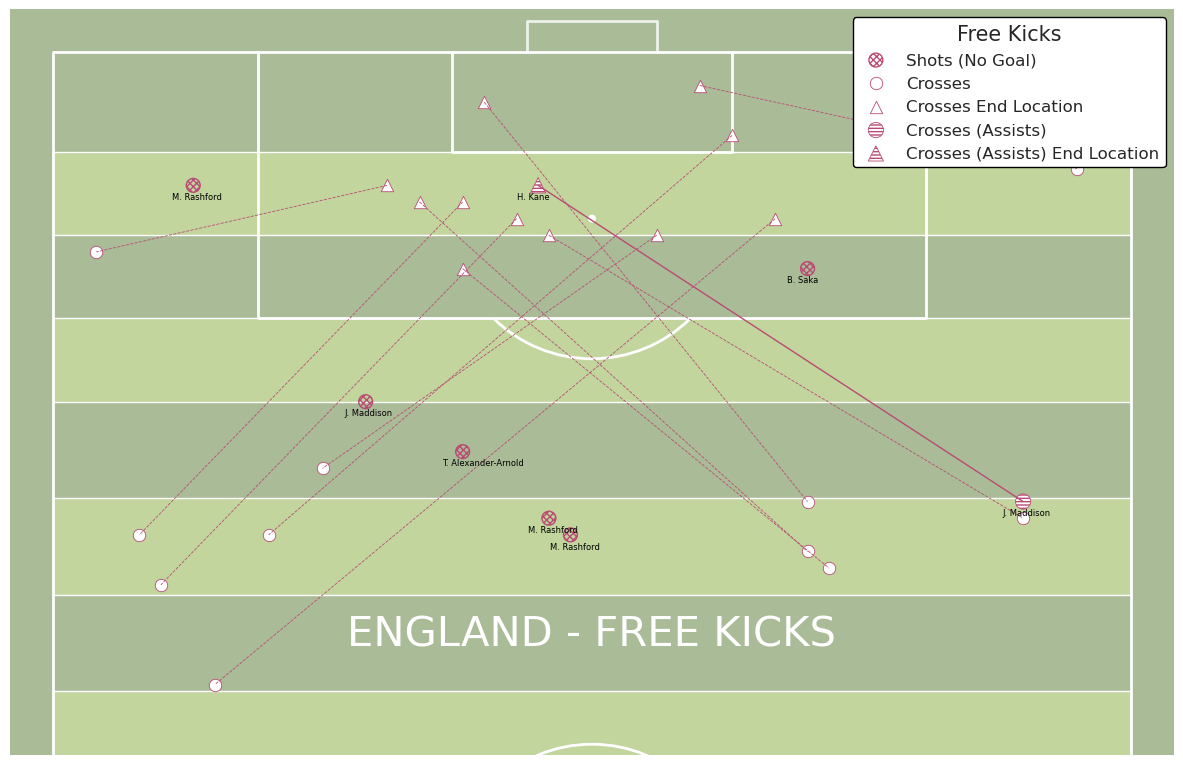

In [74]:
pitch = VerticalPitch(pitch_type='wyscout',
                      pad_bottom=-12,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      goal_alpha=0.8,
                      pitch_color='#aabb97',
                      line_color='white',
                      stripe_color='#c2d59d',
                      stripe=True)  # control the goal transparency



fig, ax = pitch.draw(figsize=(12, 10))

# plot non-goal shots with hatch


# plot goal shots with a football marker
# 'edgecolors' sets the color of the pentagons and edges, 'c' sets the color of the hexagons

sc2 = pitch.scatter(df_crosses['pass.endLocation.x'], df_crosses['pass.endLocation.y'],
                    # size varies between 100 and 1900 (points squared)
                    s=80,
                    edgecolors='#b94b75',
                    linewidths=0.6,
                    c='white',
                    marker='^',
                    ax=ax)

sc3 = pitch.scatter(df_crosses['location.x'], df_crosses['location.y'],
                    # size varies between 100 and 1900 (points squared)
                    s=80,
                    edgecolors='#b94b75',
                    linewidths=0.6,
                    c='white',
                    marker='o',
                    ax=ax)


sc4 = pitch.scatter(df_assists['pass.endLocation.x'], df_assists['pass.endLocation.y'],
                    # size varies between 100 and 1900 (points squared)
                    s=120,
                    edgecolors='#b94b75',
                    linewidths=0.6,
                    hatch = '-----',
                    c='white',
                    marker='^',
                    ax=ax)

sc5 = pitch.scatter(df_assists['location.x'], df_assists['location.y'],
                    # size varies between 100 and 1900 (points squared)
                    s=120,
                    edgecolors='#b94b75',
                    linewidths=0.6,
                    hatch = '-----',
                    c='white',
                    marker='o',
                    ax=ax)

sc1 = pitch.scatter(df_shots['location.x'], df_shots['location.y'],
                    # size varies between 100 and 1900 (points squared)
                    s=100,
                    edgecolors='#b94b75',  # give the markers a charcoal border
                    c='None',  # no facecolor for the markers
                    # for other markers types see: https://matplotlib.org/api/markers_api.html
                    hatch = 'xxxxx',
                    marker='o',
                    ax=ax)


for i in range(len(df_assists)):
    pitch.annotate(df_assists['pass.recipient.name'].iloc[i],
                 xy=(df_assists['pass.endLocation.x'].iloc[i], df_assists['pass.endLocation.y'].iloc[i]),
                 xytext=(-10, -15),
                 textcoords='offset points',
                 fontsize=6,
                 color='black',
                 ax =ax)
    
for i in range(len(df_assists)):
    pitch.annotate(df_assists['player.name'].iloc[i],
                 xy=(df_assists['location.x'].iloc[i], df_assists['location.y'].iloc[i]),
                 xytext=(-10, -15),
                 textcoords='offset points',
                 fontsize=6,
                 color='black',
                 ax =ax)
    
for i in range(len(df_shots)):
    pitch.annotate(df_shots['player.name'].iloc[i],
                 xy=(df_shots['location.x'].iloc[i], df_shots['location.y'].iloc[i]),
                 xytext=(-10, -15),
                 textcoords='offset points',
                 fontsize=6,
                 color='black',
                 ax =ax)
    

for i in range(len(df_crosses)):
    pitch.plot([df_crosses['pass.endLocation.x'].iloc[i], df_crosses['location.x'].iloc[i]],
            [df_crosses['pass.endLocation.y'].iloc[i], df_crosses['location.y'].iloc[i]],
            color='#b94b75', linestyle='--', linewidth=0.6, ax=ax)

for i in range(len(df_assists)):
    pitch.plot([df_assists['pass.endLocation.x'].iloc[i], df_assists['location.x'].iloc[i]],
            [df_assists['pass.endLocation.y'].iloc[i], df_assists['location.y'].iloc[i]],
            color='#b94b75', linestyle='-', linewidth=1, ax=ax)

ax.legend([sc1, sc3, sc2, sc5, sc4], ['Shots (No Goal)', 'Crosses', 'Crosses End Location', 'Crosses (Assists)', 'Crosses (Assists) End Location'],
          loc='upper right', fontsize=12, title_fontsize=15, title='Free Kicks', facecolor='white', edgecolor='black', framealpha=1)

txt = ax.text(x=50, y=65, s='ENGLAND - FREE KICKS',
              size=30,
              # here i am using a downloaded font from google fonts instead of passing a fontdict
              color=pitch.line_color,
              va='center', ha='center')

From the plot above it really does not seem like England are a big threat from free-kicks at least. Of the ones that came in as crosses, only one ended up a shot. Note also, that it seems like one of the free-kicks was taken from inside the penalty area, which is impossible. We see however in the clip that this was quite a clever routine by Saka and Maddison so don't be surprised if we see any creative or unusual set-pieces from England in the upcoming Euros.

## Corners

In [75]:
corner_data = df_concat_England[df_concat_England['type.primary'] == 'corner']
corner_data = corner_data.dropna(axis=1, how='all')
corner_data = corner_data[corner_data['team.name'] == 'England']
corner_data.shape

(36, 47)

In [76]:
corner_takers = player_names = corner_data['player.name'].unique().tolist()
corner_takers

['J. Maddison',
 'P. Foden',
 'T. Alexander-Arnold',
 'K. Trippier',
 'L. Shaw',
 'J. Grealish',
 'B. Chilwell',
 'J. Henderson',
 'B. Saka']

In [77]:
corner_takers_foot_dict = {'player.name': corner_takers,
                      'foot': ["Left", "Left", "Right", "Right", "Right", "Left", "Left", "Right", "Right"]}

corner_takers_foot = pd.DataFrame(corner_takers_foot_dict)

In [78]:
corner_takers_foot

,player.name,foot
0,J. Maddison,Left
1,P. Foden,Left
2,T. Alexander-Arnold,Right
3,K. Trippier,Right
4,L. Shaw,Right
5,J. Grealish,Left
6,B. Chilwell,Left
7,J. Henderson,Right
8,B. Saka,Right


In [79]:
#res2 = pd.merge([corner_data, corner_takers_foot], on="player.name")
corner_data_foot = pd.merge(corner_data, corner_takers_foot, on="player.name", how="inner")

corner_data_foot['swing'] = np.where(
    ((corner_data_foot['location.y'] == 0) & (corner_data_foot['foot'] == 'Right')) | 
    ((corner_data_foot['location.y'] == 100) & (corner_data_foot['foot'] == 'Left')),
    'Inswinging',
    'Outswinging'
)

#corner_data_foot

In [102]:
#corner_data_foot

In [80]:
short_corners = corner_data_foot[corner_data_foot['pass.length']<19] #For Wyscout data the penalty area begins after 19 units from the corner flag
long_corners = corner_data_foot[corner_data_foot['pass.length']>=19]

non_acc_corners = corner_data_foot[corner_data_foot['pass.accurate']==False]
acc_no_shot_corners = corner_data_foot[(corner_data_foot['pass.accurate']==True) & (corner_data_foot['possession.attack.withShot']==False)]
acc_shot_corners = corner_data_foot[(corner_data_foot['pass.accurate']==True) & (corner_data_foot['possession.attack.withShot']==True)]

inswing_corners = corner_data_foot[(corner_data_foot['swing']=="Inswinging")]
outswing_corners = corner_data_foot[(corner_data_foot['swing']=="Outswinging")]

In [81]:
print("short_corners: ", short_corners.shape[0])
print("long_corners: ", long_corners.shape[0])

print("non_acc_corners:", non_acc_corners.shape[0])
print("acc_corners_no_shot:", acc_no_shot_corners.shape[0])
print("acc_corners_shot:", acc_shot_corners.shape[0])

print("Inswinging corners: ", inswing_corners.shape[0])
print("Outswinging corners: ", outswing_corners.shape[0])

short_corners:  1
long_corners:  35
non_acc_corners: 5
acc_corners_no_shot: 20
acc_corners_shot: 11
Inswinging corners:  12
Outswinging corners:  24


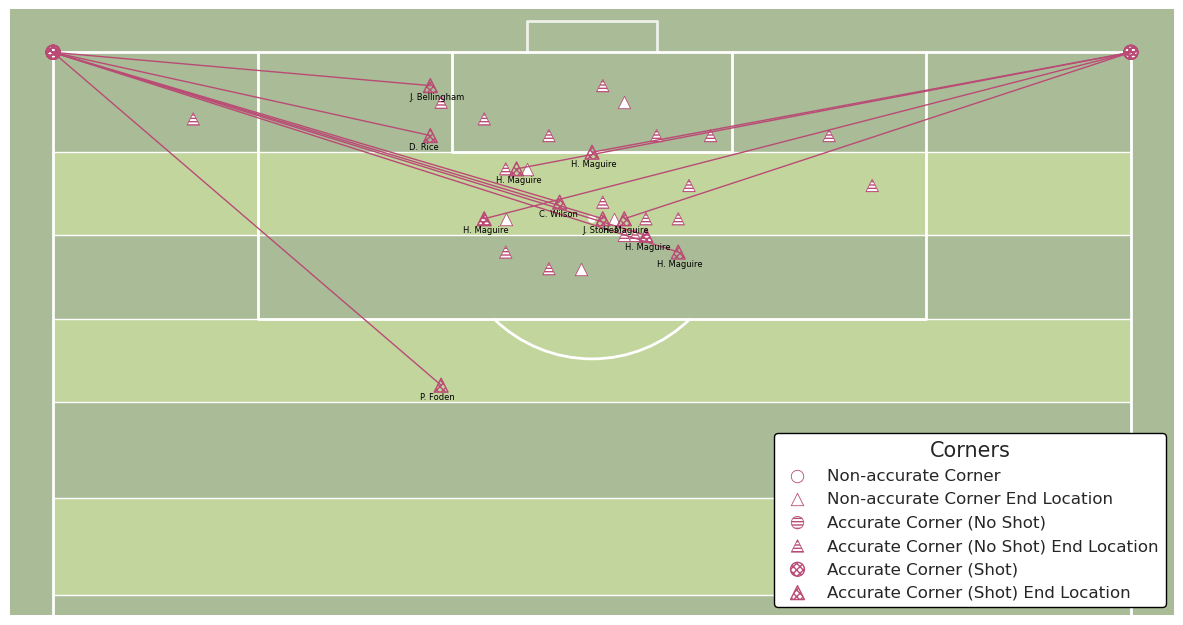

In [82]:
pitch = VerticalPitch(pitch_type='wyscout',
                      pad_bottom=-25,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      goal_alpha=0.8,
                      pitch_color='#aabb97',
                      line_color='white',
                      stripe_color='#c2d59d',
                      stripe=True)  # control the goal transparency

fig, ax = pitch.draw(figsize=(12, 10))

# plot non-goal shots with hatch


# plot goal shots with a football marker
# 'edgecolors' sets the color of the pentagons and edges, 'c' sets the color of the hexagons

sc1 = pitch.scatter(non_acc_corners['location.x'], non_acc_corners['location.y'],
                    # size varies between 100 and 1900 (points squared)
                    s=80,
                    edgecolors='#b94b75',
                    linewidths=0.6,
                    c='white',
                    marker='o',
                    ax=ax)

sc2 = pitch.scatter(non_acc_corners['pass.endLocation.x'], non_acc_corners['pass.endLocation.y'],
                    # size varies between 100 and 1900 (points squared)
                    s=80,
                    edgecolors='#b94b75',
                    linewidths=0.6,
                    c='white',
                    marker='^',
                    ax=ax)

sc3 = pitch.scatter(acc_no_shot_corners['location.x'], acc_no_shot_corners['location.y'],
                    # size varies between 100 and 1900 (points squared)
                    s=80,
                    edgecolors='#b94b75',
                    linewidths=0.6,
                    c='white',
                    marker='o',
                    hatch='-----',
                    ax=ax)

sc4 = pitch.scatter(acc_no_shot_corners['pass.endLocation.x'], acc_no_shot_corners['pass.endLocation.y'],
                    # size varies between 100 and 1900 (points squared)
                    s=80,
                    edgecolors='#b94b75',
                    linewidths=0.6,
                    c='white',
                    marker='^',
                    hatch='-----',
                    ax=ax)

sc5 = pitch.scatter(acc_shot_corners['location.x'], acc_shot_corners['location.y'],
                    # size varies between 100 and 1900 (points squared)
                    s=100,
                    edgecolors='#b94b75',  # give the markers a charcoal border
                    c='None',  # no facecolor for the markers
                    # for other markers types see: https://matplotlib.org/api/markers_api.html
                    hatch = 'xxxxx',
                    marker='o',
                    ax=ax)

sc6 = pitch.scatter(acc_shot_corners['pass.endLocation.x'], acc_shot_corners['pass.endLocation.y'],
                    # size varies between 100 and 1900 (points squared)
                    s=100,
                    edgecolors='#b94b75',  # give the markers a charcoal border
                    c='None',  # no facecolor for the markers
                    # for other markers types see: https://matplotlib.org/api/markers_api.html
                    hatch = 'xxxxx',
                    marker='^',
                    ax=ax)


for i in range(len(acc_shot_corners)):
    pitch.annotate(acc_shot_corners['pass.recipient.name'].iloc[i],
                 xy=(acc_shot_corners['pass.endLocation.x'].iloc[i], acc_shot_corners['pass.endLocation.y'].iloc[i]),
                 xytext=(-10, -15),
                 textcoords='offset points',
                 fontsize=6,
                 color='black',
                 ax =ax)
    
# for i in range(len(acc_shot_corners)):
#     pitch.annotate(acc_shot_corners['player.name'].iloc[i],
#                  xy=(acc_shot_corners['location.x'].iloc[i], acc_shot_corners['location.y'].iloc[i]),
#                  xytext=(-10, -15),
#                  textcoords='offset points',
#                  fontsize=6,
#                  color='black',
#                  ax =ax)



for i in range(len(acc_shot_corners)):
    pitch.plot([acc_shot_corners['pass.endLocation.x'].iloc[i], acc_shot_corners['location.x'].iloc[i]],
            [acc_shot_corners['pass.endLocation.y'].iloc[i], acc_shot_corners['location.y'].iloc[i]],
            color='#b94b75', linestyle='-', linewidth=1, ax=ax)


#ax.legend([sc1, sc3, sc2, sc5, sc4], ['Shots (No Goal)', 'Crosses', 'Crosses End Location', 'Crosses (Assists)', 'Crosses (Assists) End Location'],
ax.legend([sc1, sc2, sc3, sc4, sc5, sc6], ['Non-accurate Corner', 'Non-accurate Corner End Location' ,
                                           'Accurate Corner (No Shot)', 'Accurate Corner (No Shot) End Location',
                                           'Accurate Corner (Shot)', 'Accurate Corner (Shot) End Location'],
          loc='lower right', fontsize=12, title_fontsize=15, title='Corners', facecolor='white', edgecolor='black', framealpha=1)
